In [305]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from coupling_metrics import fisher_mean
from ctf_dataset.load import create_wrapped_dataset
from ctf_dataset import info
from ctf_dataset.behaviours.heuristic import near_teammate
from pingouin import pcorr

In [123]:
# Create Wrapped dataset
base_dir = '/mnt/bucket/labs/hasson/snastase/social-ctf'
data_dir = join(base_dir, 'data')
wrap_f = create_wrapped_dataset(data_dir, output_dataset_name="virtual.hdf5")

In [35]:
n_matchups = 4
n_repeats = 8
n_players = 4
n_samples = 4501

In [48]:
# Load in PCA-reduced LSTMs
pcs = np.array([3, 4, 6, 7, 8, 9, 10])
pc_labels = [f'PC{pc}' for pc in pcs]
k = 100
lstms_pca = np.load(f'results/lstms_tanh-z_pca-k{k}.npy')[..., pcs - 1]

In [71]:
# Load in coupling time series
coop_ids = [0, 5]
iscfs = np.full((n_matchups, n_repeats, len(coop_ids), n_samples, len(pcs)), np.nan)
for matchup in np.arange(n_matchups):
    for repeat in np.arange(n_repeats):
        for p, pc in enumerate(pcs - 1):
            iscf = np.load(f'results/iscf_lstm_tanh-z_pca-k{k}'
                           f'_m{matchup}_r{repeat}.npy')[coop_ids, :, pc, pc]
            iscfs[matchup, repeat, ..., p] = iscf
        print(f"Loaded cofluctuation for matchup {matchup} repeat {repeat}")

Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repeat}
Loaded cofluctuation for matchup {matchup} repeat {repea

In [101]:
# Duplicate paired ISCFs to compare to individual players
iscfs_dup = np.repeat(iscfs, 2, axis=2)
iscf_labels = [f'CF {l}' for l in pc_labels]

In [158]:
# Stack PC and ISCF data
data_stack = [lstms_pca, iscfs_dup]

In [204]:
# Load in value functions
def get_value(matchup_id, repeat_id, player_id):
    map_id = 0
    reward = wrap_f['map/matchup/repeat/player/time/reward'][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    value = wrap_f['map/matchup/repeat/player/time/value'][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    discounted_return = wrap_f['map/matchup/repeat/player/time/discounted_return'][
        map_id, matchup_id, repeat_id, player_id, ...]
    value_stack = np.hstack((np.nan_to_num(reward),
                             np.nan_to_num(value),
                             np.nan_to_num(discounted_return)))
    value_labels = ['reward', 'value', 'discounted return']
    return value_stack, value_labels

In [205]:
# Load in health
def get_health(matchup_id, repeat_id, player_id):
    map_id = 0
    health = wrap_f['map/matchup/repeat/player/time/health'][
        map_id, matchup_id, repeat_id, player_id,...].astype(np.float32)
    return health, ['health']

In [281]:
# Get flag captures and distance to base
def get_flags(matchup_id, repeat_id, player_id):
    events_ = wrap_f["map/matchup/repeat/player/time/events"][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    color_id = wrap_f["map/matchup/repeat/player/color_id"][
        map_id, matchup_id, repeat_id, player_id, ...][0]
    if color_id == 0:
        my_color, opp_color = 'red', 'blue'
    elif color_id == 1:
        my_color, opp_color = 'blue', 'red'

    flag_position = wrap_f[f"map/matchup/repeat/time/{my_color}_flag_position"][
        map_id, matchup_id, repeat_id, ...].astype(np.float32)
    flag_status = wrap_f[f"map/matchup/repeat/time/{my_color}_flag_status"][
        map_id, matchup_id, repeat_id, ...]
    opp_base_position = wrap_f[f"map/{opp_color}_base_position"][map_id]
    flag_status = wrap_f[f"map/matchup/repeat/time/{my_color}_flag_status"][
        map_id, matchup_id, repeat_id, ...]

    dist = np.sqrt(np.sum(np.square(flag_position[..., :2] - opp_base_position[..., :2]), axis=1))
    
    captures = np.zeros(dist.shape)
    captures_t = events_[:, info.events.Events.CTF_CAPTURE_BONUS_TEAM] > 0
    captures[captures_t] = 1
                        
    returns = np.zeros(dist.shape)
    returns_t = np.nonzero(events_[1:, info.events.Events.CTF_RECOVERY_BONUS_OTHER_TEAM] > 0)[0]
    returns[returns_t] = 1
    
    my_score = wrap_f[f"map/matchup/repeat/time/{my_color}_team_score"][
        map_id, matchup_id, repeat_id, ..., 0].astype(np.float32)
    opp_score = wrap_f[f"map/matchup/repeat/time/{opp_color}_team_score"][
        map_id, matchup_id, repeat_id, ..., 0].astype(np.float32)
    
    flag_stack = np.stack((dist, captures, returns, my_score, opp_score), axis=1)
    flag_labels = ['flag distance to base',
                   'flag captures',
                   'flag returns',
                   'team score',
                   'opponent score']
    return flag_stack, flag_labels

In [245]:
# Load in distance to opponent's base
def get_base_distance(matchup_id, repeat_id, player_id):
    health = wrap_f["map/matchup/repeat/player/time/health"][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    position = wrap_f["map/matchup/repeat/player/time/position"][
        map_id, matchup_id, repeat_id, player_id, ].astype(np.float32)
    own_base_position = wrap_f["map/matchup/repeat/player/own_base_position"][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    opponent_base_position = wrap_f["map/matchup/repeat/player/opponent_base_position"][
        map_id, matchup_id, repeat_id, player_id, ...].astype(np.float32)
    own_base_position = np.expand_dims(own_base_position, axis=-2)
    opponent_base_position = np.expand_dims(opponent_base_position, axis=-2)

    position_alive = position.copy()
    position_alive[health[..., 0] == 0.0] = np.nan
    position_dead = position.copy()
    position_dead[..., 1:, :][health[..., :-1, 0] != 0.0] = np.nan

    dist = np.sqrt(np.sum(np.square(position[..., :2] - opponent_base_position[..., :2]), axis=-1))
    dist_alive = np.sqrt(np.sum(np.square(position_alive[..., :2] - opponent_base_position[..., :2]), axis=-1))
    dist_dead = np.sqrt(np.sum(np.square(position_dead[..., :2] - opponent_base_position[..., :2]), axis=-1))
    base_distance = dist[:, None]
    base_distance_labels = ['distance to opponent base']
    
    return base_distance, base_distance_labels

In [293]:
# Loop through games and stack variables to compute correlation matrix
corr_mats = []
for matchup in np.arange(n_matchups):
    for repeat in np.arange(n_repeats):
        
        nears = near_teammate(wrap_f, map_id=0, matchup_id=matchup, repeat_id=repeat,
                             min_behaviour_length=30, teammate_radius=2)
        
        for player in np.arange(n_players):
            
            # Get PC and ISCF data
            data_restack = []
            for data in data_stack:
                data_restack.append(data[matchup, repeat, player])
            data_restack = np.hstack(data_restack)
            
            # Get health
            health, health_label = get_health(matchup, repeat, player)
            
            # Get value functions
            value_stack, value_labels = get_value(matchup, repeat, player)
            
            # Get distance to opponent base
            base_distance, base_distance_labels = get_base_distance(matchup, repeat, player)
            
            # Get flag status
            flag_stack, flag_labels = get_flags(matchup, repeat, player)
            
            # Get near teammate for player
            near = nears[player]

            # Restack all data
            data_restack = np.hstack((data_restack, health, value_stack,
                                      base_distance, flag_stack, near))
            
            corr = np.nan_to_num(np.corrcoef(data_restack.T))
            if np.sum(np.isnan(corr)) > 0:
                raise
            corr_mats.append(corr)
corr_mat = fisher_mean(corr_mats, axis=0)            

In [294]:
# Set labels
label_stack = (pc_labels + iscf_labels + health_label + value_labels +
               base_distance_labels + flag_labels + ['near teammate'])
assert len(label_stack) == corr_mat.shape[0]

In [302]:
def plot_correlation_matrix(corr_mat, labels, filename=None):
    fig, ax = plt.subplots(figsize=(17, 14))
    sns.heatmap(corr_mat, vmin=-.5, vmax=.5, cmap='vlag', annot=True, ax=ax,
                fmt='.2f', square=True, xticklabels=labels, yticklabels=labels)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0)

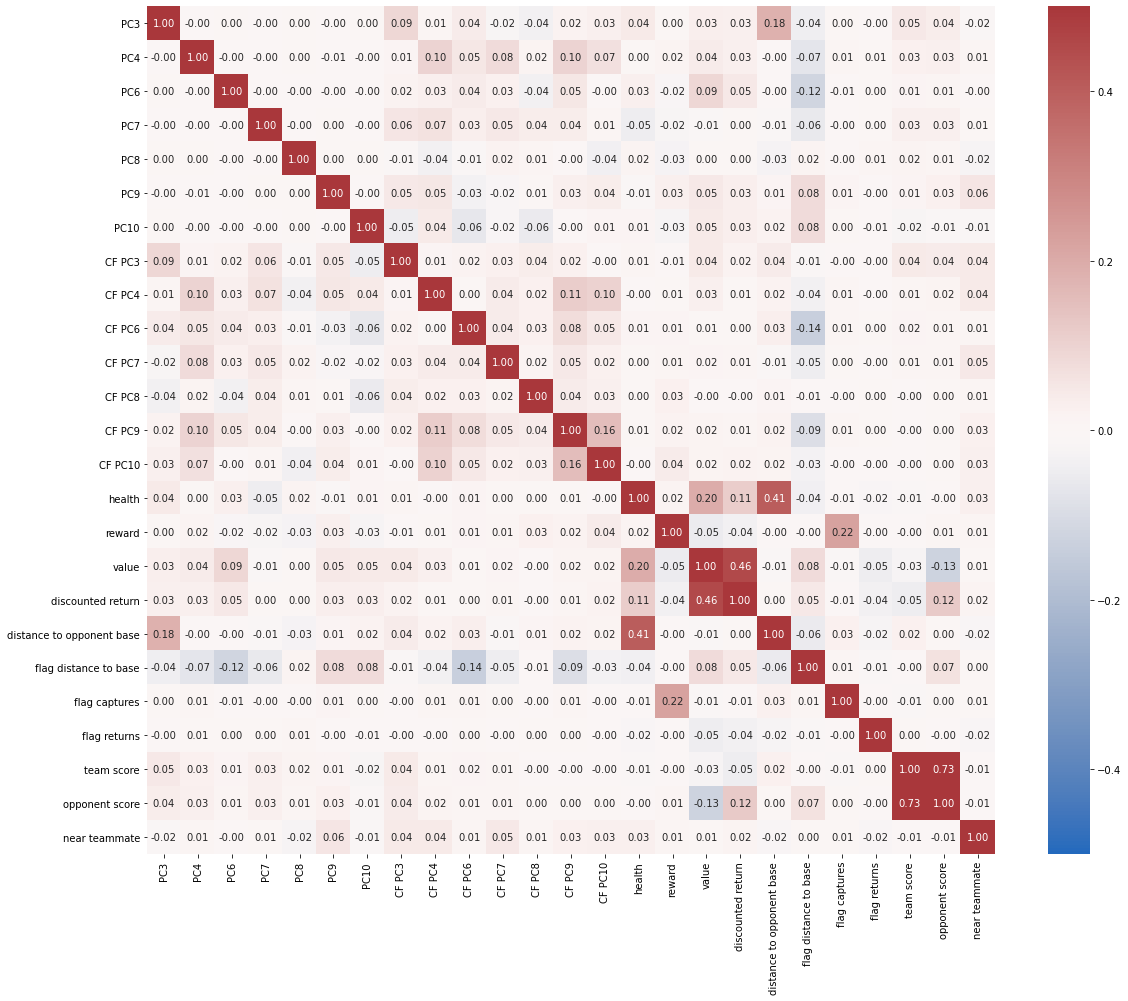

In [303]:
plot_correlation_matrix(corr_mat, label_stack, filename='figures/pc_iscf_correlation_matrix.png')

In [311]:
# Loop through games and stack variables to compute correlation matrix
corr_mats = []
for matchup in np.arange(n_matchups):
    for repeat in np.arange(n_repeats):
        
        nears = near_teammate(wrap_f, map_id=0, matchup_id=matchup, repeat_id=repeat,
                             min_behaviour_length=30, teammate_radius=2)
        
        for player in np.arange(n_players):
            
            # Get PC and ISCF data
            data_restack = []
            for data in data_stack:
                data_restack.append(data[matchup, repeat, player])
            data_restack = np.hstack(data_restack)
            
            # Get health
            health, health_label = get_health(matchup, repeat, player)
            
            # Get value functions
            value_stack, value_labels = get_value(matchup, repeat, player)
            
            # Get distance to opponent base
            base_distance, base_distance_labels = get_base_distance(matchup, repeat, player)
            
            # Get flag status
            flag_stack, flag_labels = get_flags(matchup, repeat, player)
            
            # Get near teammate for player
            near = nears[player]

            # Restack all data
            data_restack = np.hstack((data_restack, health, value_stack,
                                      base_distance, flag_stack, near))
            
            corr = np.nan_to_num(pd.DataFrame(data_restack).pcorr())
            if np.sum(np.isnan(corr)) > 0:
                raise
            corr_mats.append(corr)
corr_mat = fisher_mean(corr_mats, axis=0)   

/jukebox/hasson/snastase/miniconda3/envs/ctf/lib/python3.7/site-packages/pingouin/correlation.py:909: RuntimeWarning: divide by zero encountered in true_divide
  D = np.diag(np.sqrt(1 / np.diag(Vi)))
/jukebox/hasson/snastase/miniconda3/envs/ctf/lib/python3.7/site-packages/pingouin/correlation.py:910: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/jukebox/hasson/snastase/miniconda3/envs/ctf/lib/python3.7/site-packages/pingouin/correlation.py:909: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / np.diag(Vi)))
/mnt/bucket/labs/hasson/snastase/social-ctf/coupling_metrics.py:10: RuntimeWarning: divide by zero encountered in arctanh
  return np.tanh(np.nanmean(np.arctanh(correlations), axis=axis))
/mnt/bucket/labs/hasson/snastase/social-ctf/coupling_metrics.py:10: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(np.nanmean(np.arctanh(correlations), axis=axis))


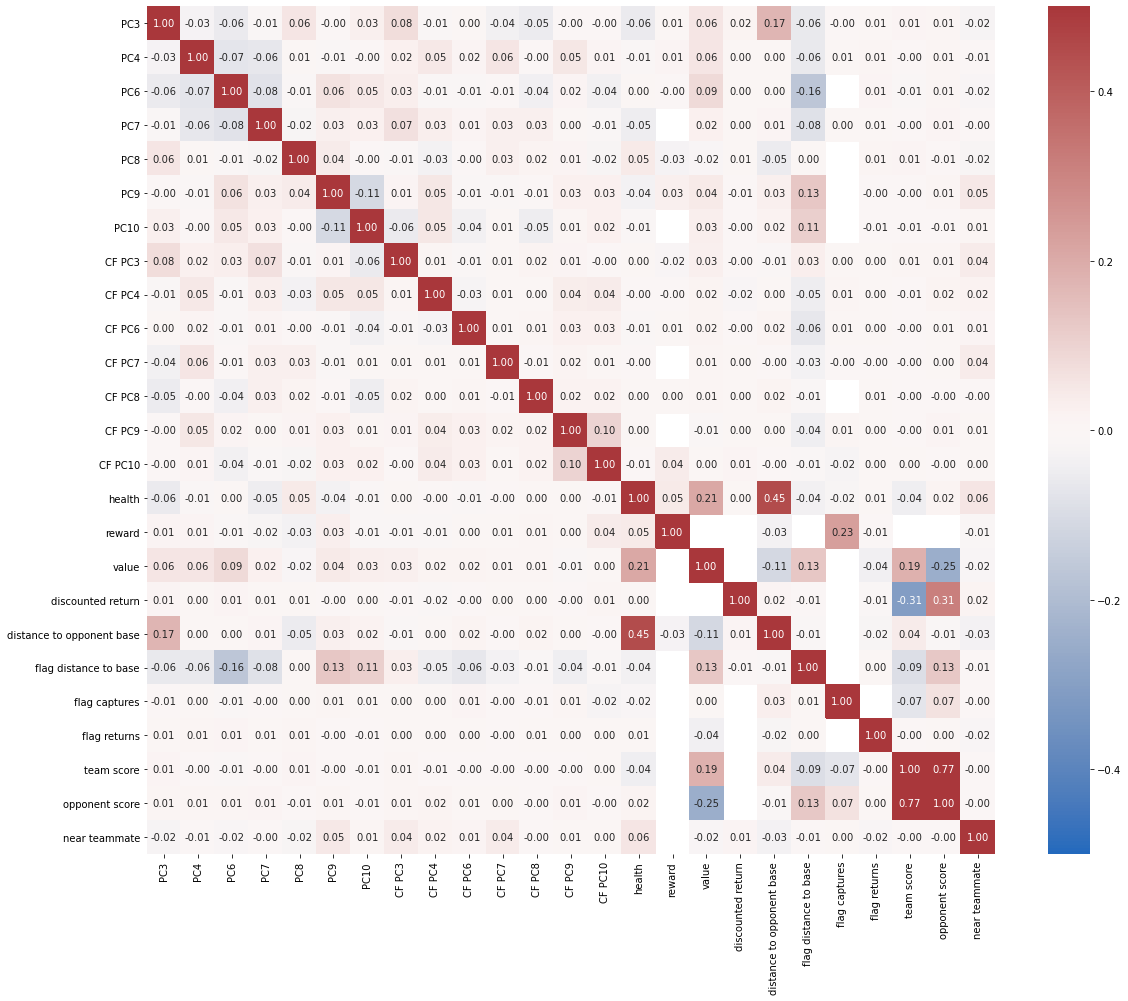

In [312]:
plot_correlation_matrix(corr_mat, label_stack, filename='figures/pc_iscf_pcorr_matrix.png')